In [ ]:
# Unzip the uploaded data into Google Drive
#!unzip "/content/drive/MyDrive/Colab Notebooks/Which is my doggy??/dog-breed-identification.zip" -d "/content/drive/MyDrive/Colab Notebooks/Which is my doggy??/"

# 🐶 End-to-end Multi-class Dog Breed Classification

This notebook builds an end-to-end multi-class image classifier using TensorFlow 2.0 and TensorFlow Hub.

## 1. Problem

Identifying the breed of a dog given an image of a dog.

When I'm sitting at the cafe and I take a photo of a dog, I want to know what breed of dog it is.

## 2. Data

The data we're using is from Kaggle's  dog breed identification competition.

https://www.kaggle.com/c/dog-breed-identification/data


## 3. Evaluation

The evaluation is a file with  prediction for each dog breed of each test image.

https://www.kaggle.com/c/dog-breed-identification/overview/evaluation

## 4. Features

Some information about the data:
* We're dealing with images(unstructured data) so it's probably best we use deep learning/transfer learning.
* There are 120 breeds of dogs (this means there are 120 different classes).
* There are around 10,000+ iamges in the training set (these images have labels)
* There are around 10,000+ images in the test set (these images no labels, because we'll want to predict them.

# Get our workspace ready

* Import TensorFlow 2.x
* Import TensorFlow Hub
* Make sure we're using a GPU


In [ ]:
# Import necessary tools
import tensorflow as tf
import tensorflow_hub as hub
print("TF version:", tf.__version__)
print("TF Hub version:", tf.__version__)

# Check for GPU availability 
print("GPU", "available (YESSSS!!!)" if tf.config.list_physical_devices("GPU") else "not available:(")

TF version: 2.4.1
TF Hub version: 2.4.1
GPU available (YESSSS!!!)



 ## Getting our data ready (turning into Tensors)

 With all machine learning models, our data has to be in numerical format. So that's what we'll be doing first. Turning our images into Tensors(numerical representation).

 Let's start by accessing our data and checking out the labels.

In [ ]:
# Checkout the labels of our data
import pandas as pd
labels_csv = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Which is my doggy??/labels.csv")
print(labels_csv.describe())
print(labels_csv.head())

                                      id               breed
count                              10222               10222
unique                             10222                 120
top     c56ff3790f57858458eebd14050f51b1  scottish_deerhound
freq                                   1                 126
                                 id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever


In [ ]:
labels_csv.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


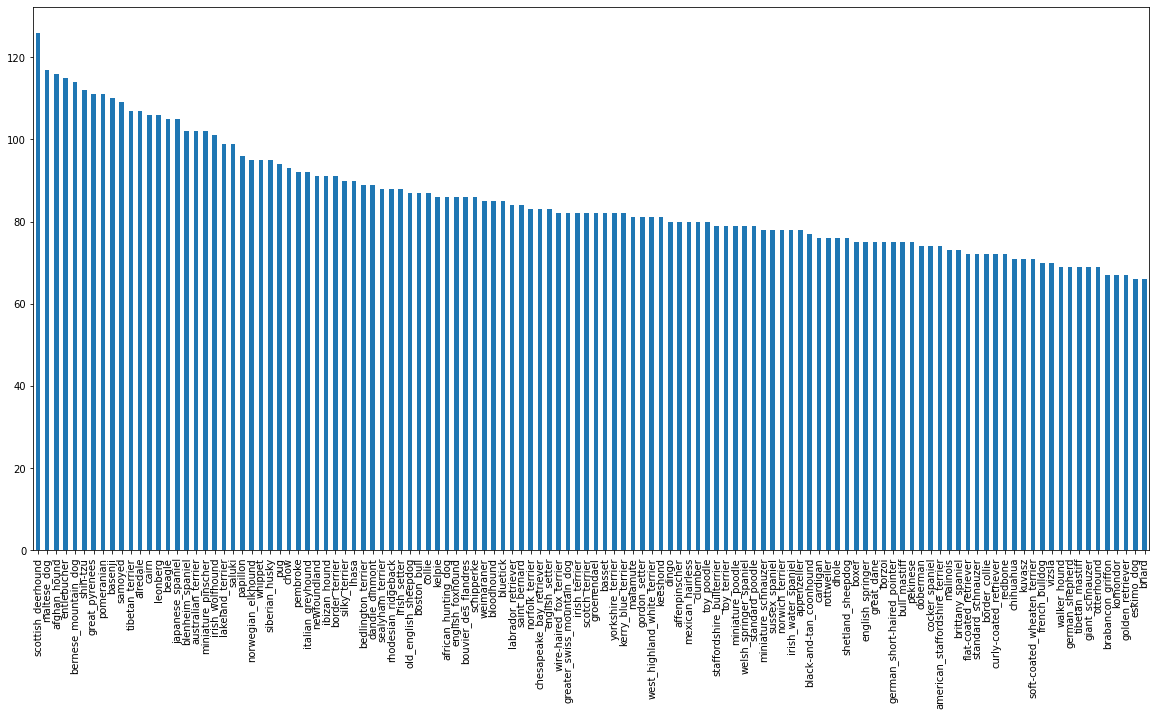

In [ ]:

# How many images are there of each breed?
labels_csv["breed"].value_counts().plot.bar(figsize=(20, 10))

In [ ]:
labels_csv["breed"].value_counts().median()

82.0

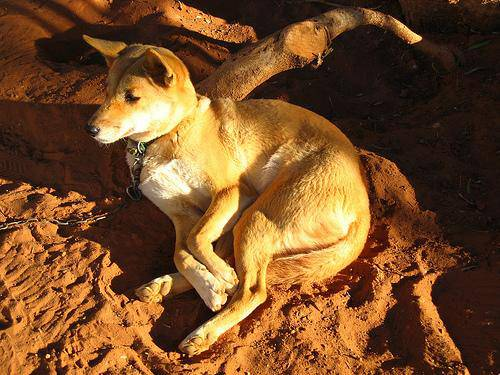

In [ ]:
# Let's view an image
from IPython.display import Image
Image("/content/drive/MyDrive/Colab Notebooks/Which is my doggy??/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg")

### Getting images and their labels
Let's get a list of all of our image file pathnames

In [ ]:
labels_csv.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [ ]:
# Create pathnames from image ID's
filenames = ["/content/drive/MyDrive/Colab Notebooks/Which is my doggy??/train/" + fname + ".jpg" for fname in labels_csv["id"]]

# Check the first 10
filenames[:10]

['/content/drive/MyDrive/Colab Notebooks/Which is my doggy??/train/000bec180eb18c7604dcecc8fe0dba07.jpg',
 '/content/drive/MyDrive/Colab Notebooks/Which is my doggy??/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg',
 '/content/drive/MyDrive/Colab Notebooks/Which is my doggy??/train/001cdf01b096e06d78e9e5112d419397.jpg',
 '/content/drive/MyDrive/Colab Notebooks/Which is my doggy??/train/00214f311d5d2247d5dfe4fe24b2303d.jpg',
 '/content/drive/MyDrive/Colab Notebooks/Which is my doggy??/train/0021f9ceb3235effd7fcde7f7538ed62.jpg',
 '/content/drive/MyDrive/Colab Notebooks/Which is my doggy??/train/002211c81b498ef88e1b40b9abf84e1d.jpg',
 '/content/drive/MyDrive/Colab Notebooks/Which is my doggy??/train/00290d3e1fdd27226ba27a8ce248ce85.jpg',
 '/content/drive/MyDrive/Colab Notebooks/Which is my doggy??/train/002a283a315af96eaea0e28e7163b21b.jpg',
 '/content/drive/MyDrive/Colab Notebooks/Which is my doggy??/train/003df8b8a8b05244b1d920bb6cf451f9.jpg',
 '/content/drive/MyDrive/Colab Notebooks/Which

In [ ]:
import os
os.listdir("/content/drive/MyDrive/Colab Notebooks/Which is my doggy??/train")[:10]

['db7d4420a51a8928e82bcb1d9a6c4167.jpg',
 'df8895a945ab874f4a9cdd451aebc011.jpg',
 'e3a8e45ac0004fb87d2ac40bad70114e.jpg',
 'dd4449d7083cbce6c5dbc4d66091652d.jpg',
 'e86a88391d017cc3807cc9653a4a7290.jpg',
 'e0c759008208229026ae7aeb04da7a75.jpg',
 'e6d9085fa22d76e3c089cfaea8f39479.jpg',
 'e4913c578cba8c59d842663fa734d337.jpg',
 'dc56a2b217661f2b3b521d8f58c1504b.jpg',
 'e39c995703aaed29660f904fa5bce520.jpg']

In [ ]:
# Check whether number of filenames matches number of actual image files
import os 
if len(os.listdir("/content/drive/MyDrive/Colab Notebooks/Which is my doggy??/train")) == len(filenames):
  print("Filenames match actual amount of files!!! Proceed.")

else:
  print("Filesnames do not match amount of files, check the target directory.")

Filenames match actual amount of files!!! Proceed.


Since we've now got out training image filepaths in a list, let's prepare our labels.

In [ ]:
import numpy as np
labels = labels_csv["breed"]
labels = np.array(labels)
labels

array(['boston_bull', 'dingo', 'pekinese', ..., 'airedale',
       'miniature_pinscher', 'chesapeake_bay_retriever'], dtype=object)

In [ ]:
len(labels)

10222

In [ ]:
# See if number of labels matches the number of filenames
if len(labels) == len(filenames):
  print("Number of labels matches number of filenames!")
else:
  print("Number of labels does not match of filenames, check data directories!")

Number of labels matches number of filenames!


In [ ]:
# Find the unique label value
unique_breeds = np.unique(labels)
len(unique_breeds)

120

In [ ]:

# Turn a single label into an array of booleans
print(labels[0])
labels[0] == unique_breeds

boston_bull


array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False])

In [ ]:

# Turn every label into a boolean array
boolean_labels = [label == unique_breeds for label in labels]
boolean_labels[:2]

[array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False,  True, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False]),
 array([False, False, False, False, False, Fal

In [ ]:

len(boolean_labels)

10222

In [ ]:


# Example Turning boolean array into integers
print(labels[0]) # original label
print(np.where(unique_breeds == labels[0])) #index where label occurs
print(boolean_labels[0].argmax()) # index where label occurs in boolean array
print(boolean_labels[0].astype(int)) #there will be a 1 where the sample label occurs

boston_bull
(array([19]),)
19
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]


In [ ]:
filenames[:10]

['/content/drive/MyDrive/Colab Notebooks/Which is my doggy??/train/000bec180eb18c7604dcecc8fe0dba07.jpg',
 '/content/drive/MyDrive/Colab Notebooks/Which is my doggy??/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg',
 '/content/drive/MyDrive/Colab Notebooks/Which is my doggy??/train/001cdf01b096e06d78e9e5112d419397.jpg',
 '/content/drive/MyDrive/Colab Notebooks/Which is my doggy??/train/00214f311d5d2247d5dfe4fe24b2303d.jpg',
 '/content/drive/MyDrive/Colab Notebooks/Which is my doggy??/train/0021f9ceb3235effd7fcde7f7538ed62.jpg',
 '/content/drive/MyDrive/Colab Notebooks/Which is my doggy??/train/002211c81b498ef88e1b40b9abf84e1d.jpg',
 '/content/drive/MyDrive/Colab Notebooks/Which is my doggy??/train/00290d3e1fdd27226ba27a8ce248ce85.jpg',
 '/content/drive/MyDrive/Colab Notebooks/Which is my doggy??/train/002a283a315af96eaea0e28e7163b21b.jpg',
 '/content/drive/MyDrive/Colab Notebooks/Which is my doggy??/train/003df8b8a8b05244b1d920bb6cf451f9.jpg',
 '/content/drive/MyDrive/Colab Notebooks/Which

### Creating our own validation set

Since the dataset from Kaggle doesn't come with a validation set, we're going to create our own.

In [ ]:
# Setup X & y variables
X = filenames
y = boolean_labels

In [ ]:
len(filenames)

10222

Wer're going to start off experimenting with ~1000 images and increased as needed.

In [ ]:
# Set number of images to use for experimenting
NUM_IMAGES = 1000 #@param {type:"slider", min:1000, max:1}

In [ ]:
# Let's split our data into train and validation sets
from sklearn.model_selection import train_test_split


# Split them into training and validation of total size NUM_IMAGES
X_train, X_val, y_train, y_val = train_test_split(X[:NUM_IMAGES],
                                                  y[:NUM_IMAGES],
                                                  test_size=0.2,
                                                  random_state=42)

len(X_train), len(y_train), len(X_val), len(y_val)

(800, 800, 200, 200)

In [ ]:
# Let's have a geez at the training data
X_train[:5], y_train[:5]

(['/content/drive/MyDrive/Colab Notebooks/Which is my doggy??/train/00bee065dcec471f26394855c5c2f3de.jpg',
  '/content/drive/MyDrive/Colab Notebooks/Which is my doggy??/train/0d2f9e12a2611d911d91a339074c8154.jpg',
  '/content/drive/MyDrive/Colab Notebooks/Which is my doggy??/train/1108e48ce3e2d7d7fb527ae6e40ab486.jpg',
  '/content/drive/MyDrive/Colab Notebooks/Which is my doggy??/train/0dc3196b4213a2733d7f4bdcd41699d3.jpg',
  '/content/drive/MyDrive/Colab Notebooks/Which is my doggy??/train/146fbfac6b5b1f0de83a5d0c1b473377.jpg'],
 [array([False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False,  True,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, Fa

## Preprocessing Images (turning images into Tensors)

To preprocess our images into Tensors we're going to write a function which does a few things:
1. Take an image filepath as input
2. Use TensorFlow to read the file and save it to a variable, image
3. Turn our image (a jpg) into Tensors
4. Resize the image to be a shape of (224, 224)
5. Return the modified image

Before we'do, let's see what importing an image looks like.

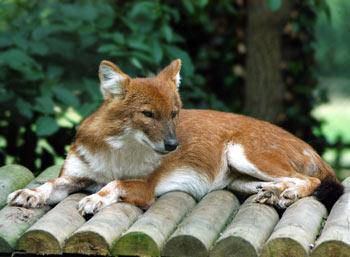

In [ ]:
from IPython.display import Image
Image("/content/drive/MyDrive/Colab Notebooks/Which is my doggy??/train/011e06760794850c40f23d6426c40774.jpg")

In [ ]:
from matplotlib.pyplot import imread
image = imread(filenames[42])
image.shape

(257, 350, 3)

In [ ]:
filenames[42]

'/content/drive/MyDrive/Colab Notebooks/Which is my doggy??/train/011e06760794850c40f23d6426c40774.jpg'

In [ ]:

image.max(), image.min()

(255, 0)

In [ ]:
image[:2]

array([[[ 89, 137,  87],
        [ 76, 124,  74],
        [ 63, 111,  59],
        ...,
        [ 76, 134,  86],
        [ 76, 134,  86],
        [ 76, 134,  86]],

       [[ 72, 119,  73],
        [ 67, 114,  68],
        [ 63, 111,  63],
        ...,
        [ 75, 131,  84],
        [ 74, 132,  84],
        [ 74, 131,  86]]], dtype=uint8)

In [ ]:
# Turn image into Tensor
tf.constant(image)[:2]

<tf.Tensor: shape=(2, 350, 3), dtype=uint8, numpy=
array([[[ 89, 137,  87],
        [ 76, 124,  74],
        [ 63, 111,  59],
        ...,
        [ 76, 134,  86],
        [ 76, 134,  86],
        [ 76, 134,  86]],

       [[ 72, 119,  73],
        [ 67, 114,  68],
        [ 63, 111,  63],
        ...,
        [ 75, 131,  84],
        [ 74, 132,  84],
        [ 74, 131,  86]]], dtype=uint8)>

In [ ]:
# Define image size
IMG_SIZE = 224

# Create a function for preprocessing images
def process_image (image_path):
  """
   Takes an image file path and turns the image into a Tensor.
  """

  # Read in an image file
  image = tf.io.read_file(image_path)
  # Turn the jpeg image into numerical Tensor with 3 colour channels (Red, Green, Blue)
  image = tf.image.decode_jpeg(image, channels=3)
  # Convert the colour channel values from 0-255 to 0-1 values
  image = tf.image.convert_image_dtype(image, tf.float32)
  # Resize the image to our desired value (224, 224)
  image = tf.image.resize(image, size=[IMG_SIZE, IMG_SIZE])

  return image

In [ ]:
tensor = tf.io.read_file(filenames[26])
tensor

<tf.Tensor: shape=(), dtype=string, numpy=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xdb\x00C\x00\n\x07\x07\x08\x07\x06\n\x08\x08\x08\x0b\n\n\x0b\x0e\x18\x10\x0e\r\r\x0e\x1d\x15\x16\x11\x18#\x1f%$"\x1f"!&+7/&)4)!"0A149;>>>%.DIC<H7=>;\xff\xdb\x00C\x01\n\x0b\x0b\x0e\r\x0e\x1c\x10\x10\x1c;("(;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;\xff\xc0\x00\x11\x08\x01\xf4\x01w\x03\x01"\x00\x02\x11\x01\x03\x11\x01\xff\xc4\x00\x1f\x00\x00\x01\x05\x01\x01\x01\x01\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x01\x02\x03\x04\x05\x06\x07\x08\t\n\x0b\xff\xc4\x00\xb5\x10\x00\x02\x01\x03\x03\x02\x04\x03\x05\x05\x04\x04\x00\x00\x01}\x01\x02\x03\x00\x04\x11\x05\x12!1A\x06\x13Qa\x07"q\x142\x81\x91\xa1\x08#B\xb1\xc1\x15R\xd1\xf0$3br\x82\t\n\x16\x17\x18\x19\x1a%&\'()*456789:CDEFGHIJSTUVWXYZcdefghijstuvwxyz\x83\x84\x85\x86\x87\x88\x89\x8a\x92\x93\x94\x95\x96\x97\x98\x99\x9a\xa2\xa3\xa4\xa5\xa6\xa7\xa8\xa9\xaa\xb2\xb3\xb4\xb5\xb6\xb7\xb8\xb9\xba\xc2\xc3\xc4\xc5\xc6\xc7\xc8\xc9\xca

In [ ]:
tensor = tf.image.decode_jpeg(tensor, channels=3)

In [ ]:

tf.image.convert_image_dtype(tensor, tf.float32)

<tf.Tensor: shape=(500, 375, 3), dtype=float32, numpy=
array([[[0.23137257, 0.26666668, 0.25490198],
        [0.2509804 , 0.28627452, 0.27450982],
        [0.2784314 , 0.3137255 , 0.3019608 ],
        ...,
        [0.45098042, 0.5019608 , 0.42352945],
        [0.45098042, 0.5019608 , 0.42352945],
        [0.43137258, 0.48235297, 0.4039216 ]],

       [[0.25490198, 0.2901961 , 0.2784314 ],
        [0.28235295, 0.31764707, 0.30588236],
        [0.30980393, 0.34509805, 0.33333334],
        ...,
        [0.44705886, 0.49803925, 0.41960788],
        [0.45882356, 0.50980395, 0.43137258],
        [0.454902  , 0.5058824 , 0.427451  ]],

       [[0.26666668, 0.3019608 , 0.2901961 ],
        [0.29803923, 0.33333334, 0.32156864],
        [0.3254902 , 0.36078432, 0.34901962],
        ...,
        [0.44705886, 0.49803925, 0.41960788],
        [0.47058827, 0.52156866, 0.4431373 ],
        [0.48235297, 0.53333336, 0.454902  ]],

       ...,

       [[0.6784314 , 0.7843138 , 0.60784316],
        [0.64

## Turning our data into batches

We're trying to process 10,000+ images in one go.. they all might not fit into memory.

So that's why we do about 32(this is the batch size) images at a time (you can manually adjust the batch size if need be).

In [ ]:
# Create a simple function to return a tuple (image, label)
def get_image_label(image_path, label):
  """
  Take an image file path name and the associated label,
  processes the image and returns a tuple of (image, label).
  """

  image = process_image(image_path)
  return image, label

In [ ]:
# Demo of the above
(process_image(X[42]), tf.constant(y[42]))

(<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
 array([[[0.3264178 , 0.5222886 , 0.3232816 ],
         [0.2537167 , 0.44366494, 0.24117757],
         [0.25699762, 0.4467087 , 0.23893751],
         ...,
         [0.29325107, 0.5189916 , 0.3215547 ],
         [0.29721776, 0.52466875, 0.33030328],
         [0.2948505 , 0.5223015 , 0.33406618]],
 
        [[0.25903144, 0.4537807 , 0.27294815],
         [0.24375686, 0.4407019 , 0.2554778 ],
         [0.2838985 , 0.47213382, 0.28298813],
         ...,
         [0.2785345 , 0.5027992 , 0.31004712],
         [0.28428748, 0.5108719 , 0.32523635],
         [0.28821915, 0.5148036 , 0.32916805]],
 
        [[0.20941195, 0.40692952, 0.25792548],
         [0.24045378, 0.43900946, 0.2868911 ],
         [0.29001117, 0.47937486, 0.32247734],
         ...,
         [0.26074055, 0.48414773, 0.30125174],
         [0.27101526, 0.49454468, 0.32096273],
         [0.27939945, 0.5029289 , 0.32934693]],
 
        ...,
 
        [[0.00634795, 0.03442048

Now we' ve got a way to our data into Tensors in the form: (image, label), Let's make a function to turn all of our data(x & y) into batches!

In [ ]:
# Define the batch size, 32 is a good start
BATCH_SIZE = 32

# Create a function to turn data into batches
def create_data_batches(X, y=None, batch_size=BATCH_SIZE, valid_data=False, test_data=False):
  """
  Creates batches of data out of image (X) and label (y) pairs.
  Shuffles the data if it's training data but doesn't shuffle if it's validation data.
  Also accepts test data as input (no labels).
  """
  # If the data is a test dataset, we probably don't have have labels
  if test_data:
    print("Creating test data batches...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X))) # only filepaths (no labels)
    data_batch = data.map(process_image).batch(BATCH_SIZE)
    return data_batch
  
  # If the data is a valid dataset, we don't need to shuffle it
  elif valid_data:
    print("Creating validation data batches...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X), # filepaths
                                               tf.constant(y))) # labels
    data_batch = data.map(get_image_label).batch(BATCH_SIZE)
    return data_batch

  else:
    print("Creating training data batches...")
    # Turn filepaths and labels into Tensors
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X),
                                               tf.constant(y)))
    # Shuffling pathnames and labels before mapping image processor function is faster than shuffling images
    data = data.shuffle(buffer_size=len(X))

    # Create (image, label) tuples (this also turns the iamge path into a preprocessed image)
    data = data.map(get_image_label)

    # Turn the training data into batches
    data_batch = data.batch(BATCH_SIZE)
  return data_batch

In [ ]:
# Create training and validation data batches
train_data = create_data_batches(X_train, y_train)
val_data = create_data_batches(X_val, y_val, valid_data=True)

Creating training data batches...
Creating validation data batches...


In [ ]:
# Check out the different  attributes of our data batches
train_data.element_spec, val_data.element_spec

((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)),
 (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)))

 # Visualizing Data Batches

Our data is now in batches, however these can be a little hard to understand/comprehense, let's visualize them!

In [ ]:
import matplotlib.pyplot as plt

# Create a function for viewing images in a data batch
def show_25_images(images, labels):
  """
  Displays a plot of 25 images and their labels from a data batch.
  """
  # Setup the figure
  plt.figure(figsize=(10, 10))
  # Loop through 25 (for displaying 25 images)
  for i in range(25):
    # Create subplots (5 rows, 5 columns)
    ax = plt.subplot(5, 5, i+1)
    # Display an image 
    plt.imshow(images[i])
    # Add the image label as the title
    plt.title(unique_breeds[labels[i].argmax()])
    # Turn the grid lines off
    plt.axis("off")

In [ ]:
train_images, train_labels = next(train_data.as_numpy_iterator())
train_images, train_labels

(array([[[[0.02352941, 0.03921569, 0.03529412],
          [0.02633053, 0.04201681, 0.03809524],
          [0.02979192, 0.04547819, 0.04155662],
          ...,
          [0.34390756, 0.39880955, 0.39880955],
          [0.33486396, 0.38976595, 0.38976595],
          [0.35148042, 0.4063824 , 0.4063824 ]],
 
         [[0.01995798, 0.03564426, 0.03172269],
          [0.02377952, 0.03946579, 0.03554422],
          [0.02745098, 0.04313726, 0.03921569],
          ...,
          [0.3345438 , 0.38944578, 0.38944578],
          [0.34908962, 0.4039916 , 0.4039916 ],
          [0.34967995, 0.40458193, 0.40458193]],
 
         [[0.01757703, 0.03326331, 0.02934174],
          [0.02095838, 0.03664466, 0.03272309],
          [0.02515006, 0.04083633, 0.03691477],
          ...,
          [0.3343037 , 0.3892057 , 0.3892057 ],
          [0.35721284, 0.41211483, 0.41211483],
          [0.34905982, 0.4039618 , 0.4039618 ]],
 
         ...,
 
         [[0.6723691 , 0.6998201 , 0.7233495 ],
          [0.68438

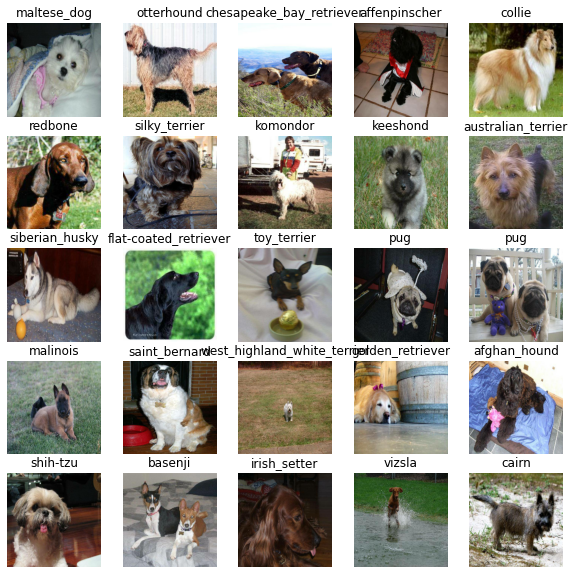

In [ ]:
# Now let's visualize the data in a training batch
show_25_images(train_images, train_labels)

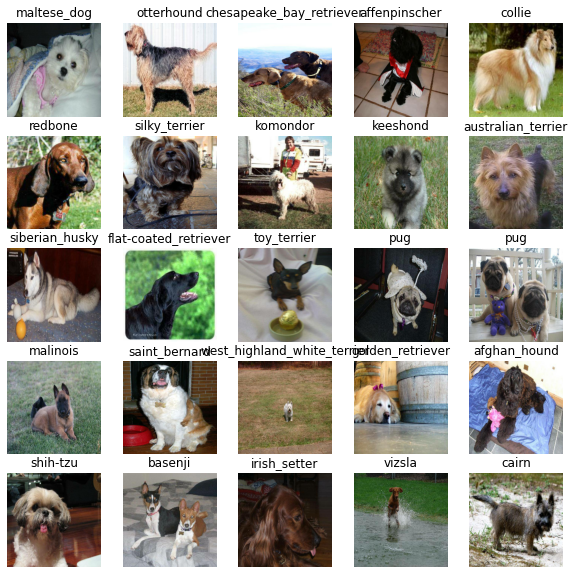

In [ ]:
# Now let's visualize our validation set
val_images, val_labels = next(train_data.as_numpy_iterator())
show_25_images(train_images, train_labels)  

## Building a model 

Before we build a model, there are a few things we need to define:
 * The input shape (our images shape, in the form of Tensors) to our model.
 * The output shape(images labels, in the form of Tensors) of our model.
 * The URL of the model we want to use from Tensorflow Hub.
 https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4

In [ ]:
# Setup input shape to the model
INPUT_SHAPE = [None, IMG_SIZE, IMG_SIZE, 3] # batch, height, width, colour channels

#Seup output shape of our model
OUTPUT_SHAPE = len(unique_breeds)

# Setup model URl from TensorFlow Hub
MODEL_URL = "https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4"

Now we've got our inputs, outpluts and model ready to go.
Let's put them together into a Keras deep learning model!
* Takes the input shape, output shape and the model we've chosen as parameters.
* Defines the layers in a Keras model in sequential fashion.
* Compiles the model (say it should be evaluated and improved).
Builds the model (tells the model the input shape it'll getting).
* Returns the model.

All of these test can be found here: https://www.tensorflow.org/guide/keras/overview

In [ ]:
# Create a function which builds a Keras model
def create_model(input_shape=INPUT_SHAPE, output_shape=OUTPUT_SHAPE, model_url=MODEL_URL):
  print("Building model with:", MODEL_URL)

  # Setup the model layers
  model = tf.keras.Sequential([
    hub.KerasLayer(MODEL_URL), # Layer 1 (input layer)
    tf.keras.layers.Dense(units=OUTPUT_SHAPE,
                          activation="softmax") # Layer 2 (output layer)
  ])

  # Compile the model
  model.compile(
      loss=tf.keras.losses.CategoricalCrossentropy(),
      optimizer=tf.keras.optimizers.Adam(),
      metrics=["accuracy"]
  )

  # Build the model
  model.build(INPUT_SHAPE)

  return model

In [ ]:
model = create_model()
model.summary()

Building model with: https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1001)              5432713   
_________________________________________________________________
dense (Dense)                (None, 120)               120240    
Total params: 5,552,953
Trainable params: 120,240
Non-trainable params: 5,432,713
_________________________________________________________________



## Creating callbacks

Creating are helper functions a model can use during training to do such things as save its progress, check its progress or stop training early if a model stops improving. 

We've create two callbacks, one for TensorBoard which helps track our models progress and another for each model from training for too long.

### TensorBoard Callback

To setup a TensorBoard callback, we need to do 3 things:
1. Load the TensorBoard notebook extension
2. Create a TennsorBoard callback which is able to save logs to a directory and pass it to our model's fit() function 
3. Visualize our model training logs with the %tensorboard magic function (we'll do this after model training).

In [ ]:
# Load TensorBoard notebook extension
%load_ext tensorboard

In [ ]:
import datetime

# Create a function to build a TensorBoard callback
def create_tensorboard_callback():
  # Create a log directory for storing TensorBoard logs
  logdir = os.path.join("/content/drive/MyDrive/Colab Notebooks/Which is my doggy??/logs",
                        # Make it so the logs get tracked whenever we run an experiment)
                        datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
  return tf.keras.callbacks.TensorBoard(logdir)

### Early Stopping Callback

Early stopping helps stop our model from overfitting by stopping training if a certain evaluation metric stops improving. 

https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping

In [ ]:
# Create early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",
                                                  patience=3)

## Training a model (on subset of data)

Our first model is only going to train 1000 images, to make sure everything is working

In [ ]:
NUM_EPOCHS = 100 #@param {type:"slider", min:10, max:100, step:10}

In [ ]:
# Check to make sure we're still running on a GPU
print("GPU", "available (YESSS!!!!)" if tf.config.list_physical_devices("GPU") else "not available :(")

GPU available (YESSS!!!!)


Let' create a function which trains a model.

* Create a model using `create_model()`
* Setup a TensorBoard callback using `callback_tensorboard_callback()`
* Call the `fit()` functiom on our model passingit the training data, validation data, number of epochs to train for (`NUM_EPOCHS`) and the callbacks we'd like to use
* Return the model

In [ ]:
# Build a function train and return a trained model
def train_model():
  """
  Trains a given model and return the trained version.
  """

  # Create a model
  model = create_model()

  # Create new TensorBoard session everything we train a model
  tensorboard = create_tensorboard_callback()

  # Fit the model to the data passing it the callbacks we created
  model.fit(x=train_data,
            epochs=NUM_EPOCHS,
            validation_data=val_data,
            validation_freq=1,
            callbacks=[tensorboard, early_stopping])
  
  # return the fitted model
  return model

In [ ]:
# Fit the model to the data
model = train_model()

Building model with: https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4
Epoch 1/100
25/25 [==============================] - 307s 11s/step - loss: 5.0832 - accuracy: 0.0538 - val_loss: 3.4537 - val_accuracy: 0.1800
Epoch 2/100
25/25 [==============================] - 4s 157ms/step - loss: 1.9282 - accuracy: 0.6263 - val_loss: 2.1909 - val_accuracy: 0.4800
Epoch 3/100
25/25 [==============================] - 4s 155ms/step - loss: 0.6350 - accuracy: 0.9358 - val_loss: 1.6886 - val_accuracy: 0.5800
Epoch 4/100
25/25 [==============================] - 4s 154ms/step - loss: 0.2522 - accuracy: 0.9822 - val_loss: 1.5116 - val_accuracy: 0.6200
Epoch 5/100
25/25 [==============================] - 4s 154ms/step - loss: 0.1470 - accuracy: 0.9979 - val_loss: 1.4327 - val_accuracy: 0.6450
Epoch 6/100
25/25 [==============================] - 4s 149ms/step - loss: 0.1002 - accuracy: 0.9972 - val_loss: 1.3898 - val_accuracy: 0.6550
Epoch 7/100
25/25 [==============================

### Checking the Tensorboard logs

The TensorBoard magic function (`%tensorboard`) will access the logs directory we created earlier and visualize its contents.



In [183]:
#%tensorboard --logdir drive/My\ Drive/\ / /logs

#%tensorboard --logdir drive/My\ Drive/Colab\ Notebooks/Which\ is/my\ doggy??/logs

## Making and evaluating predictions using a trained model

In [ ]:
val_data

<BatchDataset shapes: ((None, 224, 224, 3), (None, 120)), types: (tf.float32, tf.bool)>

In [ ]:
# Make predictions on the validation data (not used to train on)
predictions = model.predict(val_data, verbose=1)
predictions

7/7 [==============================] - 1s 111ms/step


array([[2.84243841e-03, 4.32610454e-04, 1.37392955e-03, ...,
        2.94729980e-04, 3.81161881e-05, 5.04653156e-03],
       [2.51311832e-03, 1.25139218e-03, 4.14432865e-03, ...,
        6.38343976e-04, 1.82102788e-02, 1.07072112e-04],
       [3.16608726e-04, 7.46459409e-04, 8.00001653e-05, ...,
        1.33837981e-03, 4.90646868e-04, 2.84865644e-04],
       ...,
       [3.24459943e-05, 8.44404160e-04, 3.97980875e-05, ...,
        3.51334420e-05, 2.51224294e-04, 8.35362371e-05],
       [8.83060880e-03, 2.88543612e-04, 5.48886193e-04, ...,
        2.14765387e-04, 2.50731420e-04, 4.11710842e-03],
       [4.11261246e-03, 6.96911593e-05, 1.04336785e-02, ...,
        1.89872272e-02, 2.92686746e-04, 3.50115704e-04]], dtype=float32)

In [ ]:
predictions.shape

(200, 120)

In [ ]:
len(y_val)

200

In [ ]:
len(unique_breeds)

120

In [ ]:
predictions[0]

array([2.84243841e-03, 4.32610454e-04, 1.37392955e-03, 7.19219097e-05,
       3.00019252e-04, 4.17478623e-05, 2.26484239e-02, 2.29059136e-04,
       6.26868336e-04, 3.86321160e-04, 3.51390161e-04, 2.27985904e-04,
       1.85738740e-04, 1.65725942e-05, 1.22954400e-04, 1.16645324e-03,
       7.92616047e-05, 9.55355391e-02, 1.58547613e-04, 3.96086798e-05,
       1.05473422e-03, 7.81026029e-04, 7.30657412e-05, 1.05394330e-02,
       7.82897769e-05, 7.70241662e-04, 2.70206928e-01, 4.73490400e-05,
       4.18324897e-04, 8.42930283e-04, 2.26619231e-05, 6.65311469e-04,
       3.82892624e-03, 6.65366897e-05, 8.94375335e-05, 1.75586119e-01,
       4.70690466e-05, 1.90568026e-04, 4.61245436e-05, 3.53163661e-04,
       5.08948928e-03, 2.18399116e-04, 2.76743580e-04, 1.76928501e-04,
       2.78186635e-05, 4.06125822e-04, 1.05185623e-04, 8.90812080e-04,
       1.74823357e-03, 7.83448268e-05, 5.93306671e-04, 1.39761949e-04,
       1.23173348e-04, 3.44793865e-04, 1.55472444e-04, 3.13433520e-05,
      

In [ ]:
#  First prediction
index = 42
print(predictions[0])
print(f"Max value (probability of prediction): {np.max(predictions[0])}")
print(f"Sum: {np.sum(predictions[index])}")
print(f"Max index: {np.argmax(predictions[index])}")
print(f"Predicted label: {unique_breeds[np.argmax(predictions[index])]}")

[2.84243841e-03 4.32610454e-04 1.37392955e-03 7.19219097e-05
 3.00019252e-04 4.17478623e-05 2.26484239e-02 2.29059136e-04
 6.26868336e-04 3.86321160e-04 3.51390161e-04 2.27985904e-04
 1.85738740e-04 1.65725942e-05 1.22954400e-04 1.16645324e-03
 7.92616047e-05 9.55355391e-02 1.58547613e-04 3.96086798e-05
 1.05473422e-03 7.81026029e-04 7.30657412e-05 1.05394330e-02
 7.82897769e-05 7.70241662e-04 2.70206928e-01 4.73490400e-05
 4.18324897e-04 8.42930283e-04 2.26619231e-05 6.65311469e-04
 3.82892624e-03 6.65366897e-05 8.94375335e-05 1.75586119e-01
 4.70690466e-05 1.90568026e-04 4.61245436e-05 3.53163661e-04
 5.08948928e-03 2.18399116e-04 2.76743580e-04 1.76928501e-04
 2.78186635e-05 4.06125822e-04 1.05185623e-04 8.90812080e-04
 1.74823357e-03 7.83448268e-05 5.93306671e-04 1.39761949e-04
 1.23173348e-04 3.44793865e-04 1.55472444e-04 3.13433520e-05
 8.69536016e-05 5.84338931e-03 5.09486010e-04 1.88688368e-01
 2.78691552e-03 4.35466136e-05 3.02848686e-03 4.54208821e-05
 3.56790842e-05 3.636076

In [ ]:
unique_breeds[113]

'walker_hound'

Having the above functionality is great but we want to be able to do it at scale.

And it would be even better if we could see the image the prediction is being made on:

**Note:** Prediction probabilities are also known as confidence levels.

In [ ]:

# Turn predictions probabilities into their respective label (easier to understand)
def get_pred_label(prediction_probabilities):
  """
  Turns an array of predictions probabilities into a label.

  """
  return unique_breeds[np.argmax(prediction_probabilities)]

# Get a predicted label based on an array of predictions prbabilities
pred_label = get_pred_label(predictions[81])
pred_label 

'dingo'

Now since our validation data is still in a batch dataset, we'll have to unbatchify it to make predictions on the validation images and then
compare those preditctions to the validation labels (truth labels).

In [ ]:
val_data

<BatchDataset shapes: ((None, 224, 224, 3), (None, 120)), types: (tf.float32, tf.bool)>

In [ ]:
# Create a function to unbatch a batch dataset
def unbatchify(data):
  """
  Takes a batched dataset of (image, label) Tensors and reutrns separate arrays
  of images and labels.
  """
  images = []
  labels = []
  # Loop through unbatched data
  for image, label in data.unbatch().as_numpy_iterator():
    images.append(image)
    labels.append(unique_breeds[np.argmax(label)])
  return images, labels

# Unbatchify the validation data
val_images, val_labels = unbatchify(val_data)
val_images[0], val_labels[0]

(array([[[0.29599646, 0.43284872, 0.3056691 ],
         [0.26635826, 0.32996926, 0.22846507],
         [0.31428418, 0.2770141 , 0.22934894],
         ...,
         [0.77614343, 0.82320225, 0.8101595 ],
         [0.81291157, 0.8285351 , 0.8406944 ],
         [0.8209297 , 0.8263737 , 0.8423668 ]],
 
        [[0.2344871 , 0.31603682, 0.19543913],
         [0.3414841 , 0.36560842, 0.27241898],
         [0.45016077, 0.40117094, 0.33964607],
         ...,
         [0.7663987 , 0.8134138 , 0.81350833],
         [0.7304248 , 0.75012016, 0.76590735],
         [0.74518913, 0.76002574, 0.7830809 ]],
 
        [[0.30157745, 0.3082587 , 0.21018331],
         [0.2905954 , 0.27066195, 0.18401104],
         [0.4138316 , 0.36170745, 0.2964005 ],
         ...,
         [0.79871625, 0.8418535 , 0.8606443 ],
         [0.7957738 , 0.82859945, 0.8605655 ],
         [0.75181633, 0.77904975, 0.8155256 ]],
 
        ...,
 
        [[0.9746779 , 0.9878955 , 0.9342279 ],
         [0.99153054, 0.99772066, 0.94278

In [ ]:
images_ = []
labels_ = []

# Loop through unbatched data
for image, label in val_data.unbatch().as_numpy_iterator():
  images_.append(image)
  labels_.append(label)

images_[0], labels_[0]


(array([[[0.29599646, 0.43284872, 0.3056691 ],
         [0.26635826, 0.32996926, 0.22846507],
         [0.31428418, 0.2770141 , 0.22934894],
         ...,
         [0.77614343, 0.82320225, 0.8101595 ],
         [0.81291157, 0.8285351 , 0.8406944 ],
         [0.8209297 , 0.8263737 , 0.8423668 ]],
 
        [[0.2344871 , 0.31603682, 0.19543913],
         [0.3414841 , 0.36560842, 0.27241898],
         [0.45016077, 0.40117094, 0.33964607],
         ...,
         [0.7663987 , 0.8134138 , 0.81350833],
         [0.7304248 , 0.75012016, 0.76590735],
         [0.74518913, 0.76002574, 0.7830809 ]],
 
        [[0.30157745, 0.3082587 , 0.21018331],
         [0.2905954 , 0.27066195, 0.18401104],
         [0.4138316 , 0.36170745, 0.2964005 ],
         ...,
         [0.79871625, 0.8418535 , 0.8606443 ],
         [0.7957738 , 0.82859945, 0.8605655 ],
         [0.75181633, 0.77904975, 0.8155256 ]],
 
        ...,
 
        [[0.9746779 , 0.9878955 , 0.9342279 ],
         [0.99153054, 0.99772066, 0.94278

In [ ]:
get_pred_label(labels_[0])

'cairn'

In [ ]:
get_pred_label(predictions[0])

'cairn'

Now we've got ways to get:
* Prediction labels
* Validation labels (truth labels)
* Validation images  

Let's make some functions to make these all a bit more visualize.

We'll create a function which:
* Takes an array of predictions probabilities, an array of truth labels and an array of images and integers.
* Convert the prediction probabilities to a predicted labels.
* Plot the predicted labels, its predicted probability, the truth label and the target image on a single plot.

In [ ]:
def plot_pred(prediction_probabilities, labels, images, n=1):
  """
  View the prediction, ground truth and image for sample n
  """
  pred_prob, true_label, image = prediction_probabilities[n], labels[n], images[n]

  # Get the pred label
  pred_label = get_pred_label(pred_prob)

  # Plot image & remove ticks
  plt.imshow(image)
  plt.xticks([])
  plt.yticks([])

  # Change the colour of the title depending on if the prediction is right or wrong
  if pred_label == true_label:
    color = "green"
  else:
    color = "red"
  
  # Change plot title to be predicted, probability of prediction and truth label
  plt.title("{} {:2.0f}% {}".format(pred_label,
                                    np.max(pred_prob)*100,
                                    true_label),
                                    color=color)

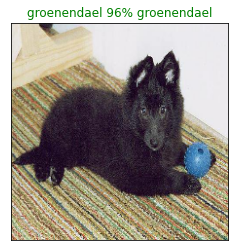

In [ ]:
plot_pred(prediction_probabilities=predictions,
          labels=val_labels,
          images=val_images,
          n=77)

Now we've got one function to visualize our models top prediction, let's make another to view our models top 10 predictions

This function will:
* Take an input of prediction probabilities array and a ground truth array and an integer ✅
* Find the prediction using get_pred_label() ✅
* Find the top 10:
  * Prediction probabilities indexes ✅
  * Prediction probabilities values ✅
  * Prediction labels ✅
* Plot the top 10 prediction probability values and labels, coloring the true label green ✅



In [ ]:
def plot_pred_conf(prediction_probabilities, labels, n=1):
  """
  Plus the top 10 highest prediction confidences along with the truth label for sample n.
  """
  pred_prob, true_label = prediction_probabilities[n], labels[n]

  # Get the predicted label
  pred_label = get_pred_label(pred_prob)

  # Find the top 10 prediction confidence indexes
  top_10_pred_indexes = pred_prob.argsort()[-10:][::-1]
  # Find the top 10 prediction confidence values
  top_10_pred_values = pred_prob[top_10_pred_indexes]
  # Find the top 10 prediction labels
  top_10_pred_labels = unique_breeds[top_10_pred_indexes]

  # Setup plot
  top_plot = plt.bar(np.arange(len(top_10_pred_labels)),
                     top_10_pred_values,
                     color="grey")
  plt.xticks(np.arange(len(top_10_pred_labels)),
             labels=top_10_pred_labels,
             rotation="vertical")
  
  # Change color of true label
  if np.isin(true_label, top_10_pred_labels):
    top_plot[np.argmax(top_10_pred_labels == true_label)].set_color("green")
  else:
    pass

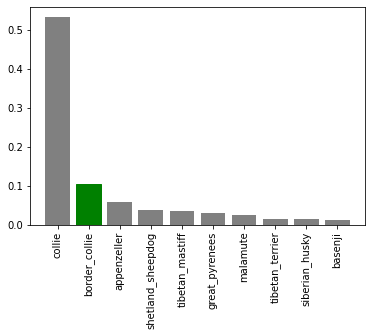

In [ ]:
plot_pred_conf(prediction_probabilities=predictions,
               labels=val_labels,
               n=9)

Now we've got some function to help us visualize our predictions and evaluate our model, let's check out 

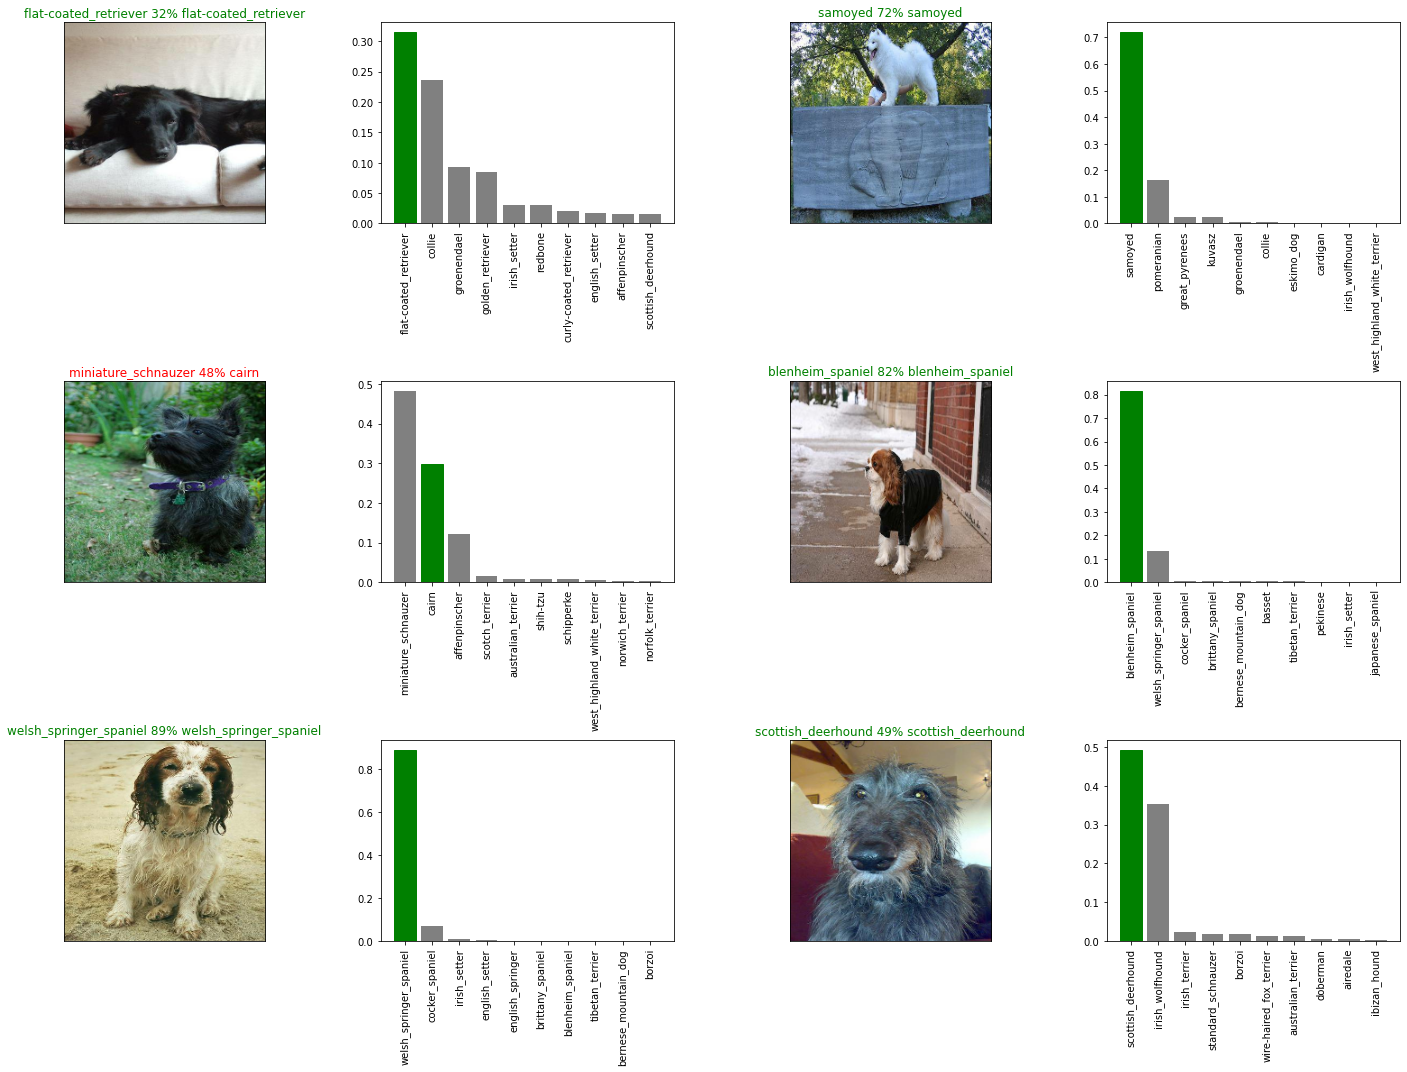

In [ ]:
# Let's check out a few predictions and their different values
i_multiplier = 20
num_rows = 3
num_cols = 2
num_images = num_rows*num_cols
plt.figure(figsize=(10*num_cols, 5*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_pred(prediction_probabilities=predictions,
            labels=val_labels,
            images=val_images,
            n=i+i_multiplier)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_pred_conf(prediction_probabilities=predictions,
                 labels=val_labels,
                 n=i+i_multiplier)
plt.tight_layout(h_pad=1.0)
plt.show()


##Saving and reloading a trained model

In [ ]:
# Create a function to save and model
def save_model(model, suffix=None):

  """
  Saves a given model in a  models directory and append a suffix (string).
  """

  # Create a model directory pathanmes with current time
  modeldir = os.path.join("/content/drive/MyDrive/Colab Notebooks/Which is my doggy??/models",
                        datetime.datetime.now().strftime("%Y%m%d-%H%M%s"))
  model_path = modeldir + "_"  + suffix + ".h5" # save format of model
  print(f"Saving model to: {model_path}...")
  model.save(model_path)
  return model_path

In [ ]:
# Create a function to load a trained model
def  load_model(model_path):
  """
  Loads a saved model from a specified path.
  """
  print(f"Loading saved from: {model_path}")
  model = tf.keras.models.load_model(model_path,
                                     custom_objects={"KerasLayer":hub.KerasLayer})
  
  return model

Now we've got functions to save and load a trained model, let's make sure they work!

In [ ]:
# Save our model trained on 10000 images
save_model(model, suffix="1000-images-mobilenetv2-Adam")

Saving model to: /content/drive/MyDrive/Colab Notebooks/Which is my doggy??/models/20210419-02581618801123_1000-images-mobilenetv2-Adam.h5...


'/content/drive/MyDrive/Colab Notebooks/Which is my doggy??/models/20210419-02581618801123_1000-images-mobilenetv2-Adam.h5'

In [ ]:
# Load a trained model 
loaded_1000_image_model = load_model('/content/drive/MyDrive/Colab Notebooks/Which is my doggy??/models/20210418-16061618761981_1000-images-mobilenetv2-Adam.h5')

Loading saved from: /content/drive/MyDrive/Colab Notebooks/Which is my doggy??/models/20210418-16061618761981_1000-images-mobilenetv2-Adam.h5


In [ ]:
# Evaluate the pre-saved model
model.evaluate(val_data)

7/7 [==============================] - 1s 103ms/step - loss: 1.3230 - accuracy: 0.6550


[1.323029637336731, 0.6549999713897705]

In [ ]:
# Evaluate the loaded model
loaded_1000_image_model.evaluate(val_data)

7/7 [==============================] - 1s 107ms/step - loss: 1.3881 - accuracy: 0.6400


[1.388077735900879, 0.6399999856948853]

## Training a big dog model (on the full data)


In [ ]:
len(X), len(y)

(10222, 10222)

In [ ]:
# Create a data batch with the full data set
full_data = create_data_batches(X, y)

Creating training data batches...


In [ ]:
full_data

<BatchDataset shapes: ((None, 224, 224, 3), (None, 120)), types: (tf.float32, tf.bool)>

In [ ]:
# Create a model for full model
full_model = create_model()

Building model with: https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4


In [ ]:
# Create full model callbacks
full_model_tensorboard = create_tensorboard_callback()
# No validation set when training on all the data, so we can't monitor validation accuracy
full_model_early_stopping = tf.keras.callbacks.EarlyStopping(monitor="accuracy",
                                                             patience = 3)

In [ ]:
# Fit the full model to the full data
full_model.fit(x=full_data,
              epochs=NUM_EPOCHS,
              callbacks=[full_model_tensorboard, full_model_early_stopping])

Epoch 1/100
320/320 [==============================] - 2845s 9s/step - loss: 2.3657 - accuracy: 0.4849
Epoch 2/100
320/320 [==============================] - 38s 119ms/step - loss: 0.3885 - accuracy: 0.8884
Epoch 3/100
320/320 [==============================] - 38s 119ms/step - loss: 0.2308 - accuracy: 0.9377
Epoch 4/100
320/320 [==============================] - 38s 120ms/step - loss: 0.1397 - accuracy: 0.9720
Epoch 5/100
320/320 [==============================] - 38s 119ms/step - loss: 0.0974 - accuracy: 0.9829
Epoch 6/100
320/320 [==============================] - 39s 120ms/step - loss: 0.0683 - accuracy: 0.9900
Epoch 7/100
320/320 [==============================] - 38s 120ms/step - loss: 0.0550 - accuracy: 0.9928
Epoch 8/100
320/320 [==============================] - 38s 120ms/step - loss: 0.0431 - accuracy: 0.9949
Epoch 9/100
320/320 [==============================] - 39s 121ms/step - loss: 0.0367 - accuracy: 0.9962
Epoch 10/100
320/320 [==============================] - 39s 120ms

In [ ]:
 save_model(full_model, suffix="full-image-set-mobilenetv2-Adam")

Saving model to: /content/drive/MyDrive/Colab Notebooks/Which is my doggy??/models/20210419-04201618806030_full-image-set-mobilenetv2-Adam.h5...


'/content/drive/MyDrive/Colab Notebooks/Which is my doggy??/models/20210419-04201618806030_full-image-set-mobilenetv2-Adam.h5'

In [ ]:
# Load full model
loaded_full_model = load_model('/content/drive/MyDrive/Colab Notebooks/Which is my doggy??/models/20210419-04201618806030_full-image-set-mobilenetv2-Adam.h5')

Loading saved from: /content/drive/MyDrive/Colab Notebooks/Which is my doggy??/models/20210419-04201618806030_full-image-set-mobilenetv2-Adam.h5


## Making predictions on the test dataset

To make predictions on the test data, we'll:
* Get the test image filenames
* Convert the filenames into test data batches using `create_data_batches()` and setting the `test_data` parameter to `True` (since the test data doesn't have labels).
* Make a predictions array by passing the test batches to the `predict()` method called on our model.

In [ ]:
# Load test image filenames
test_path = "drive/MyDrive/Colab Notebooks/Which is my doggy??/test/"
test_filenames = [test_path + fname for fname in os.listdir(test_path)]
test_filenames[:10]

['drive/MyDrive/Colab Notebooks/Which is my doggy??/test/dcb5d319bd013bbfa9779d8c6c11a829.jpg',
 'drive/MyDrive/Colab Notebooks/Which is my doggy??/test/e46f65254fdf01d5fe732068c844efbd.jpg',
 'drive/MyDrive/Colab Notebooks/Which is my doggy??/test/e52a4321a8cb0dd3bcc8f4a68b75eee7.jpg',
 'drive/MyDrive/Colab Notebooks/Which is my doggy??/test/e27567e188000db387977cdb9bbdcf82.jpg',
 'drive/MyDrive/Colab Notebooks/Which is my doggy??/test/e6a5c18da7beedb1622bf7d18b452121.jpg',
 'drive/MyDrive/Colab Notebooks/Which is my doggy??/test/e2b6d4957b62934bd831c3a1b65e2ebb.jpg',
 'drive/MyDrive/Colab Notebooks/Which is my doggy??/test/e59d59ffbb65d9eae166d4068af5d9b9.jpg',
 'drive/MyDrive/Colab Notebooks/Which is my doggy??/test/e7340d1efa70bf6d6c134e1e150f9473.jpg',
 'drive/MyDrive/Colab Notebooks/Which is my doggy??/test/df7d17082d1b25eeba9be835a150db01.jpg',
 'drive/MyDrive/Colab Notebooks/Which is my doggy??/test/de6cc38e54a460dd34c53b74f022a8da.jpg']

In [ ]:
# Create test data batch
test_data = create_data_batches(test_filenames, test_data=True)


Creating test data batches...


In [ ]:
test_data

<BatchDataset shapes: (None, 224, 224, 3), types: tf.float32>

In [ ]:
# Make predictions on test data batch using the loaded full model
test_predictions = loaded_full_model.predict(test_data,
                                             verbose=1)

324/324 [==============================] - 2891s 9s/step


In [144]:
# Save predictions (Numpy array) to csv file (for access later)
np.savetxt("/content/drive/MyDrive/Colab Notebooks/Which is my doggy??/preds_array.csv", test_predictions, delimiter=",")

In [145]:
# Load predictions (Numpy array) from csv file
test_predictions = np. loadtxt("drive/MyDrive/Colab Notebooks/Which is my doggy??/preds_array.csv", delimiter=",")

In [146]:
test_predictions[:10]

array([[2.86958213e-09, 3.49409038e-06, 6.17636786e-08, ...,
        1.87669649e-08, 2.30644281e-09, 1.70991316e-05],
       [7.76526213e-06, 6.39940878e-11, 4.70365191e-10, ...,
        1.74043668e-09, 5.95107253e-12, 5.80029180e-08],
       [1.67217115e-06, 1.88162798e-04, 2.04338555e-08, ...,
        1.67011525e-08, 1.39439305e-08, 7.39359407e-10],
       ...,
       [4.30488922e-10, 3.35853144e-07, 1.10469589e-09, ...,
        6.89284279e-05, 1.06286764e-10, 8.80459816e-10],
       [1.20408156e-10, 2.28605004e-12, 3.53367398e-08, ...,
        2.63352708e-12, 5.76386196e-11, 1.86161714e-13],
       [1.04728420e-10, 1.18843815e-07, 1.42250371e-08, ...,
        7.16808813e-07, 2.39810248e-07, 1.34850042e-09]])

In [147]:
test_predictions.shape

(10357, 120)

## Preparing test dataset predictions for Kaggle 

Looking at the Kaggle sample submission, we find that it wants our models predictions probability outputs in a DataFrame with an ID and a column for each different dog breed.
https://www.kaggle.com/c/dog-breed-identification/overview/evaluation

To get the data in this format, we'll:
* Create a panda DataFrame with an ID column as well as a column for each dog breed
* Add data to the ID column by extracting  the test image ID's from their filepaths.
* Add data (the predictions probabilties) to each of the dog breed columns.
* Export the DataFrame as a CSV to submit it to Kaggle.

In [148]:
# Create a pandas DataFrame with empty columns
preds_df = pd.DataFrame(columns=["id"] + list(unique_breeds))
preds_df.head()

,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,beagle,bedlington_terrier,bernese_mountain_dog,black-and-tan_coonhound,blenheim_spaniel,bloodhound,bluetick,border_collie,border_terrier,borzoi,boston_bull,bouvier_des_flandres,boxer,brabancon_griffon,briard,brittany_spaniel,bull_mastiff,cairn,cardigan,chesapeake_bay_retriever,chihuahua,chow,clumber,cocker_spaniel,collie,curly-coated_retriever,dandie_dinmont,dhole,dingo,doberman,...,norwegian_elkhound,norwich_terrier,old_english_sheepdog,otterhound,papillon,pekinese,pembroke,pomeranian,pug,redbone,rhodesian_ridgeback,rottweiler,saint_bernard,saluki,samoyed,schipperke,scotch_terrier,scottish_deerhound,sealyham_terrier,shetland_sheepdog,shih-tzu,siberian_husky,silky_terrier,soft-coated_wheaten_terrier,staffordshire_bullterrier,standard_poodle,standard_schnauzer,sussex_spaniel,tibetan_mastiff,tibetan_terrier,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier


In [153]:
# Append test image ID's to predictions DataFrame
test_ids = [os.path.splitext(path)[0] for path in os.listdir(test_path)]
preds_df["id"] = test_ids

In [154]:
preds_df.head()

,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,beagle,bedlington_terrier,bernese_mountain_dog,black-and-tan_coonhound,blenheim_spaniel,bloodhound,bluetick,border_collie,border_terrier,borzoi,boston_bull,bouvier_des_flandres,boxer,brabancon_griffon,briard,brittany_spaniel,bull_mastiff,cairn,cardigan,chesapeake_bay_retriever,chihuahua,chow,clumber,cocker_spaniel,collie,curly-coated_retriever,dandie_dinmont,dhole,dingo,doberman,...,norwegian_elkhound,norwich_terrier,old_english_sheepdog,otterhound,papillon,pekinese,pembroke,pomeranian,pug,redbone,rhodesian_ridgeback,rottweiler,saint_bernard,saluki,samoyed,schipperke,scotch_terrier,scottish_deerhound,sealyham_terrier,shetland_sheepdog,shih-tzu,siberian_husky,silky_terrier,soft-coated_wheaten_terrier,staffordshire_bullterrier,standard_poodle,standard_schnauzer,sussex_spaniel,tibetan_mastiff,tibetan_terrier,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
0,dcb5d319bd013bbfa9779d8c6c11a829,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,e46f65254fdf01d5fe732068c844efbd,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,e52a4321a8cb0dd3bcc8f4a68b75eee7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,e27567e188000db387977cdb9bbdcf82,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,e6a5c18da7beedb1622bf7d18b452121,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [156]:
 # Add the predictions probabilities to each dog breed column
 preds_df[list(unique_breeds)] = test_predictions
 preds_df.head()

,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,beagle,bedlington_terrier,bernese_mountain_dog,black-and-tan_coonhound,blenheim_spaniel,bloodhound,bluetick,border_collie,border_terrier,borzoi,boston_bull,bouvier_des_flandres,boxer,brabancon_griffon,briard,brittany_spaniel,bull_mastiff,cairn,cardigan,chesapeake_bay_retriever,chihuahua,chow,clumber,cocker_spaniel,collie,curly-coated_retriever,dandie_dinmont,dhole,dingo,doberman,...,norwegian_elkhound,norwich_terrier,old_english_sheepdog,otterhound,papillon,pekinese,pembroke,pomeranian,pug,redbone,rhodesian_ridgeback,rottweiler,saint_bernard,saluki,samoyed,schipperke,scotch_terrier,scottish_deerhound,sealyham_terrier,shetland_sheepdog,shih-tzu,siberian_husky,silky_terrier,soft-coated_wheaten_terrier,staffordshire_bullterrier,standard_poodle,standard_schnauzer,sussex_spaniel,tibetan_mastiff,tibetan_terrier,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
0,dcb5d319bd013bbfa9779d8c6c11a829,2.86958e-09,3.49409e-06,6.17637e-08,2.93972e-10,2.86787e-08,3.52536e-11,3.27815e-07,2.10662e-09,6.54259e-09,4.32784e-09,1.90169e-11,4.12197e-08,3.72831e-09,9.93226e-08,1.89396e-08,2.93283e-09,1.46771e-10,1.0791e-09,2.57083e-10,2.42739e-10,1.39355e-09,2.94234e-08,8.88575e-10,2.01218e-05,2.71369e-10,1.30579e-05,1.38131e-08,2.64155e-11,6.12602e-10,1.1734e-09,1.76633e-09,2.78397e-07,1.66047e-06,1.04079e-10,1.48215e-10,1.69768e-08,2.3966e-11,4.07807e-10,4.66876e-11,...,7.66357e-11,1.36304e-09,6.0216e-07,2.1416e-06,3.70401e-08,4.10323e-07,2.02846e-09,1.56863e-08,1.03869e-10,3.46864e-09,1.33109e-08,3.03421e-06,1.41196e-09,4.88495e-07,3.26046e-10,3.76463e-09,1.83006e-12,1.87678e-10,1.35763e-07,2.54828e-10,0.56599,1.31598e-08,3.96892e-06,5.08966e-06,1.21967e-07,9.17965e-13,1.72556e-09,7.9292e-09,1.70171e-05,0.0606666,1.38523e-06,1.78951e-10,5.59903e-09,7.53735e-13,7.6748e-09,1.04174e-11,8.27278e-12,1.8767e-08,2.30644e-09,1.70991e-05
1,e46f65254fdf01d5fe732068c844efbd,7.76526e-06,6.39941e-11,4.70365e-10,7.95658e-10,1.20087e-09,3.29119e-10,7.17274e-11,3.8335e-08,1.61816e-09,9.03556e-09,2.80597e-09,2.8174e-10,2.85636e-08,7.99626e-11,4.68579e-08,4.64486e-08,1.97073e-08,9.12941e-08,2.46291e-11,1.73441e-06,1.61322e-08,4.70264e-08,1.4705e-06,3.61318e-10,8.77318e-10,0.000928004,1.83708e-09,3.40159e-12,1.37588e-08,5.84134e-09,6.19995e-08,2.93548e-10,8.26469e-11,1.20437e-10,1.01627e-08,6.2051e-10,5.98084e-11,1.38414e-08,1.4417e-08,...,1.07128e-08,2.10113e-11,7.60462e-10,1.59989e-10,2.80668e-12,5.53679e-05,2.02572e-11,1.62156e-09,0.998998,1.90003e-06,1.23028e-09,1.29131e-07,1.49682e-07,1.89426e-10,8.16604e-10,5.99305e-09,1.05135e-10,3.20361e-11,2.61747e-08,4.2174e-10,1.38328e-06,3.41111e-10,4.20107e-08,4.75226e-07,2.53031e-09,1.41506e-11,7.44543e-09,2.13573e-08,2.01226e-10,1.32178e-10,2.1581e-09,2.07378e-10,6.58744e-09,1.22706e-09,1.37839e-07,1.95939e-10,1.11732e-11,1.74044e-09,5.95107e-12,5.80029e-08
2,e52a4321a8cb0dd3bcc8f4a68b75eee7,1.67217e-06,0.000188163,2.04339e-08,2.57708e-08,1.19708e-08,7.81816e-08,1.53124e-07,3.61172e-09,7.26779e-08,1.50926e-10,1.82689e-08,1.30477e-05,1.14296e-07,2.4357e-08,5.72473e-06,1.70816e-07,0.000237075,1.22508e-10,1.56318e-07,2.40084e-09,9.06715e-08,1.18396e-09,3.47831e-10,1.85837e-05,1.17101e-09,2.22718e-05,9.16821e-10,9.13757e-10,1.26574e-07,2.39758e-11,0.000317186,1.57748e-06,2.93154e-07,4.12512e-06,1.74234e-07,9.52036e-10,8.49644e-07,3.45506e-08,6.78057e-09,...,1.62864e-08,9.68778e-09,1.80509e-07,2.8553e-07,6.00628e-07,8.87901e-05,1.22759e-09,4.02038e-10,1.18723e-08,6.68378e-08,3.63566e-07,4.27143e-07,0.000486449,1.92466e-06,1.13383e-06,3.11734e-07,8.27411e-07,1.84073e-06,5.54799e-08,1.0911e-06,1.74781e-07,6.7492e-10,8.83244e-08,8.94917e-10,8.35461e-08,5.60339e-06,1.04997e-08,1.10858e-06,0.923454,6.60434e-05,5.27464e-09,6.37278e-09,3.49811e-10,6.31119e-08,2.52452e-07,3.08926e-11,2.04124e-

In [172]:
# Save our predictions dataframe to CSV for submission to Kaggle
preds_df.to_csv("drive/MyDrive/Colab Notebooks/Which is my doggy??/full_model_predictions_submission_1_mobilenetV2.csv",
                index=False)

## Making predictions on custom images

To make predictions on custom images, we'll:
* Get the fileapaths of our own images.
* Turn the filepaths into data batches using `create_data_batches()`.  And since our custom images won't have labels, we set the `test_data` parameter to `True`.
* Pass the custom image data batch to our model's `predict()` mathod.
* Convert the prediction output probabilities to predictions label.
* Compare the predictedd labels to the custom images.

In [173]:
# Get custom image filepaths
custom_path = "drive/MyDrive/Colab Notebooks/Which is my doggy??/my-dog-photos/"
custom_image_paths = [custom_path + fname for fname in os.listdir(custom_path)]

In [174]:
custom_image_paths

['drive/MyDrive/Colab Notebooks/Which is my doggy??/my-dog-photos/00e71e327e114433191f34054c6bf6f5.jpg',
 'drive/MyDrive/Colab Notebooks/Which is my doggy??/my-dog-photos/00d6e16493e6af2886292fa8823bdfe0.jpg',
 'drive/MyDrive/Colab Notebooks/Which is my doggy??/my-dog-photos/00e3fd599b69899cba0a4939f66a1745.jpg',
 'drive/MyDrive/Colab Notebooks/Which is my doggy??/my-dog-photos/20180622092303.jpg',
 'drive/MyDrive/Colab Notebooks/Which is my doggy??/my-dog-photos/20181228213859.jpg']

In [175]:
# Turn custom images into batch datasets
custom_data = create_data_batches(custom_image_paths, test_data=True)
custom_data

Creating test data batches...


<BatchDataset shapes: (None, 224, 224, 3), types: tf.float32>

In [176]:
# Make predictions on the custom data
custom_preds = loaded_full_model.predict(custom_data)

In [177]:
custom_preds.shape

(5, 120)

In [178]:
# Get custom images predictions labels
custom_pred_labels = [get_pred_label(custom_preds[i]) for i in range(len(custom_preds))]
custom_pred_labels

['blenheim_spaniel',
 'brabancon_griffon',
 'border_collie',
 'golden_retriever',
 'golden_retriever']

In [179]:
# Get custom images (our unbatchify() function won't work since there aren't labels...)
custom_images = []
# Loop through unbatched data
for image in custom_data.unbatch().as_numpy_iterator():
  custom_images.append(image)

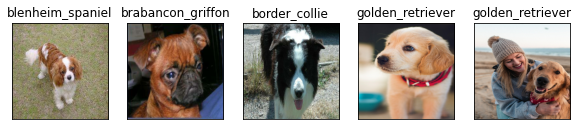

In [182]:
plt.figure(figsize=(10, 10))
for i, image in enumerate(custom_images):
  plt.subplot(1, 5, i+1)
  plt.xticks([])
  plt.yticks([])
  plt.title(custom_pred_labels[i])
  plt.imshow(image)